Jumlah Data Test: 568 sample

>> Testing Mode: Keras_GPU ...
   Result Keras_GPU: FPS=10.4 | Dice=0.9029

>> Testing Mode: TFLite ...
   [TFLite] Input Shape: [  1 256 256   3]
   Result TFLite: FPS=158.2 | Dice=0.9002

>> Testing Mode: Keras_CPU ...


/usr/local/lib/python3.12/site-packages/keras/src/models/functional.py:241: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['input_layer']
Received: inputs=Tensor(shape=(1, 256, 256, 3))
  warnings.warn(msg)


   Result Keras_CPU: FPS=8.3 | Dice=0.9029

          Dice Coef (Acc) Dice Loss Inference Time    FPS Model Size
Keras_GPU          0.9029    0.0971       96.16 ms   10.4   11.70 MB
TFLite             0.9002    0.0998        6.32 ms  158.2    1.08 MB
Keras_CPU          0.9029    0.0971      120.09 ms    8.3   11.70 MB

Visualisasi disimpan sebagai 'benchmark_viz.png'.


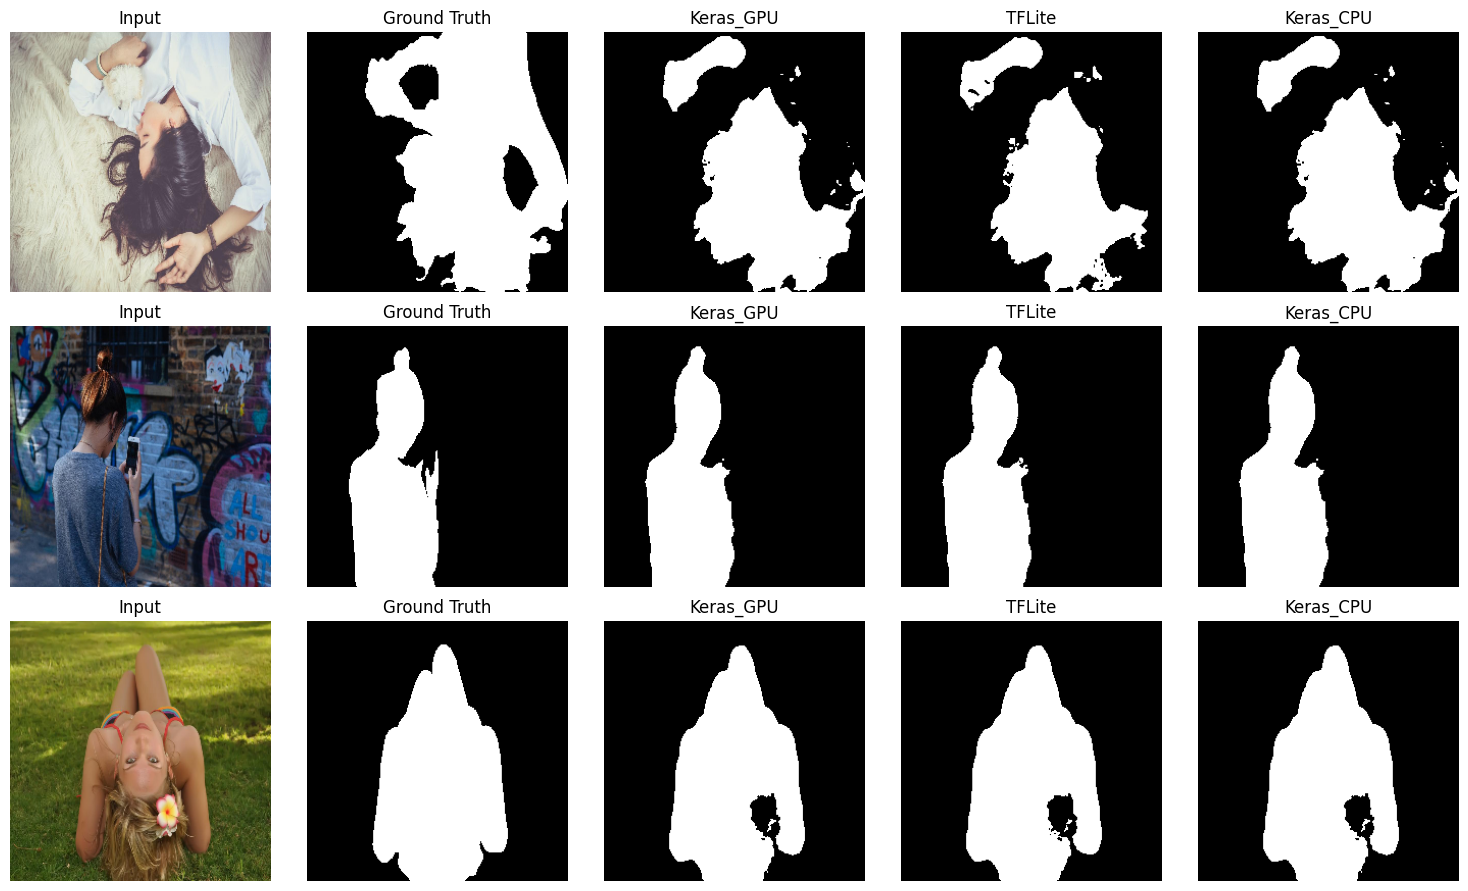

In [3]:
import gc
import os
import cv2
import time
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

# ==========================================
# 1. SETUP GPU
# ==========================================
GPUS = tf.config.list_physical_devices('GPU')
IS_GPU_AVAILABLE = len(GPUS) > 0
if IS_GPU_AVAILABLE:
    try:
        for gpu in GPUS:
            tf.config.experimental.set_memory_growth(gpu, True)
    except RuntimeError as e:
        print(f"GPU Error: {e}")

# ==========================================
# 2. IMPORT TFLITE INTERPRETER
# ==========================================
try:
    from ai_edge_litert.interpreter import Interpreter
    IS_LITERT = True
except ImportError:
    try:
        from tensorflow.lite.python.interpreter import Interpreter
    except ImportError:
        from tensorflow.lite.interpreter import Interpreter
    IS_LITERT = False

# ==========================================
# 3. KONFIGURASI & CUSTOM OBJECTS
# ==========================================
IMG_SIZE = 256
DATA_DIR = "dataset/people_segmentation"
KERAS_MODEL_PATH = "best_model_fixed.keras"
TFLITE_MODEL_PATH = "model_quantized.tflite"
NUM_SAMPLES_VISUALIZATION = 3
NUM_THREADS_TFLITE = 4

# --- Custom Objects untuk Load Model Keras ---
def dice_coef(y_true, y_pred):
    # Implementasi Tensorflow Graph (agar load_model tidak error)
    y_true_f = tf.reshape(tf.cast(y_true, tf.float32), [-1])
    y_pred_f = tf.reshape(tf.cast(y_pred, tf.float32), [-1])
    intersection = tf.reduce_sum(y_true_f * y_pred_f)
    smooth = 1e-5
    return (2. * intersection + smooth) / (tf.reduce_sum(y_true_f) + tf.reduce_sum(y_pred_f) + smooth)

def bce_dice_loss(y_true, y_pred):
    return tf.keras.losses.binary_crossentropy(y_true, y_pred) + (1.0 - dice_coef(y_true, y_pred))

# ==========================================
# 4. CLASS INFERENCE
# ==========================================
class ModelInference:
    def __init__(self, mode):
        self.mode = mode
        self.model = None
        self.interpreter = None
        self.input_details = None
        self.output_details = None
        self.tf_function_predict = None 
        self.load_model()

    def load_model(self):
        if self.mode == "TFLite":
            self.interpreter = Interpreter(model_path=TFLITE_MODEL_PATH, num_threads=NUM_THREADS_TFLITE)
            self.interpreter.allocate_tensors()
            self.input_details = self.interpreter.get_input_details()
            self.output_details = self.interpreter.get_output_details()
            print(f"   [TFLite] Input Shape: {self.input_details[0]['shape']}")

        elif self.mode == "Keras_CPU":
            with tf.device('/CPU:0'):
                self.model = tf.keras.models.load_model(
                    KERAS_MODEL_PATH, 
                    custom_objects={'dice_coef': dice_coef, 'bce_dice_loss': bce_dice_loss},
                    compile=False
                )

        elif self.mode == "Keras_GPU":
            self.model = tf.keras.models.load_model(
                KERAS_MODEL_PATH, 
                custom_objects={'dice_coef': dice_coef, 'bce_dice_loss': bce_dice_loss},
                compile=False
            )
            @tf.function(jit_compile=True) 
            def predict_step(inputs):
                return self.model(inputs, training=False)
            self.tf_function_predict = predict_step
            # Warmup dengan data range 0-255
            dummy = tf.random.uniform((1, IMG_SIZE, IMG_SIZE, 3), minval=0, maxval=255, dtype=tf.float32)
            _ = self.tf_function_predict(dummy)

    def predict(self, img_input):
        # img_input shape: (1, 256, 256, 3) range 0-255
        if self.mode == "TFLite":
            self.interpreter.set_tensor(self.input_details[0]['index'], img_input)
            self.interpreter.invoke()
            return self.interpreter.get_tensor(self.output_details[0]['index'])[0]

        elif self.mode == "Keras_CPU":
            with tf.device('/CPU:0'):
                return self.model(img_input, training=False).numpy()[0]

        elif self.mode == "Keras_GPU":
            if IS_GPU_AVAILABLE:
                return self.tf_function_predict(img_input).numpy()[0]
            return np.zeros((IMG_SIZE, IMG_SIZE, 1))

    def get_model_size(self):
        path = TFLITE_MODEL_PATH if self.mode == "TFLite" else KERAS_MODEL_PATH
        return os.path.getsize(path) / (1024 * 1024) if os.path.exists(path) else 0.0

# ==========================================
# 5. DATA UTILS & METRIC (PERBAIKAN DI SINI)
# ==========================================
def calc_dice_metric(y_true, y_pred):
    """Hard Dice untuk evaluasi akhir"""
    y_true_f = y_true.flatten()
    # Threshold prediksi menjadi biner
    y_pred_bin = (y_pred > 0.5).astype(np.float32)
    y_pred_f = y_pred_bin.flatten()
    
    intersection = np.sum(y_true_f * y_pred_f)
    union = np.sum(y_true_f) + np.sum(y_pred_f)
    
    # Jika keduanya kosong (background benar tertebak background), dice = 1
    if union == 0: return 1.0
    
    return (2. * intersection) / (union + 1e-7)

def preprocess_image(img_path, mask_path):
    # --- 1. Image ---
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img_orig = cv2.resize(img, (IMG_SIZE, IMG_SIZE))
    
    img_input = img_orig.astype(np.float32) 
    
    # --- 2. Mask ---
    mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
    mask = cv2.resize(mask, (IMG_SIZE, IMG_SIZE))
    
    # Normalisasi Mask ke 0.0 - 1.0
    if np.max(mask) > 1:
        mask = mask / 255.0
    
    mask = (mask > 0.5).astype(np.float32)
    mask = np.expand_dims(mask, axis=-1)
    
    return img_input, mask, img_orig

def get_data():
    img_dir = os.path.join(DATA_DIR, "images")
    mask_dir = os.path.join(DATA_DIR, "masks")
    img_paths = sorted([os.path.join(img_dir, f) for f in os.listdir(img_dir) if f.endswith(('.jpg', '.png'))])
    mask_paths = sorted([os.path.join(mask_dir, f) for f in os.listdir(mask_dir) if f.endswith(('.png', '.jpg'))])
    
    min_len = min(len(img_paths), len(mask_paths))
    # Gunakan split yang sama dengan training (random_state=42)
    _, x_test, _, y_test = train_test_split(img_paths[:min_len], mask_paths[:min_len], test_size=0.1, random_state=42)
    return x_test, y_test

# ==========================================
# 6. MAIN LOOP
# ==========================================
def run_benchmark():
    x_test, y_test = get_data()
    MAX_TEST = 999 
    if len(x_test) > MAX_TEST: x_test, y_test = x_test[:MAX_TEST], y_test[:MAX_TEST]
    print(f"Jumlah Data Test: {len(x_test)} sample")

    modes = ["TFLite", "Keras_CPU"]
    if IS_GPU_AVAILABLE: modes.insert(0, "Keras_GPU")
    
    results = {}
    visuals = {'input': [], 'ground_truth': []}

    for mode in modes:
        print(f"\n>> Testing Mode: {mode} ...")
        try:
            engine = ModelInference(mode)
        except Exception as e:
            print(f"Skipping {mode}: {e}")
            continue

        times, dices = [], []
        
        for i in range(len(x_test)):
            img_in, mask_true, img_orig = preprocess_image(x_test[i], y_test[i])
            img_batch = np.expand_dims(img_in, axis=0) # Shape (1, 256, 256, 3)
            
            start = time.perf_counter() 
            pred = engine.predict(img_batch)
            end = time.perf_counter()
            
            times.append(end - start)
            
            # Hitung Dice
            score = calc_dice_metric(mask_true, pred)
            dices.append(score)
            
            # Simpan Visualisasi
            if i < NUM_SAMPLES_VISUALIZATION:
                if mode == modes[0]:
                    visuals['input'].append(img_orig)
                    visuals['ground_truth'].append(mask_true)
                if mode not in visuals: visuals[mode] = []
                visuals[mode].append(pred)

        avg_time = np.mean(times)
        avg_dice = np.mean(dices)
        dice_loss = 1.0 - avg_dice 

        res = {
            "Dice Coef (Acc)": f"{avg_dice:.4f}",
            "Dice Loss": f"{dice_loss:.4f}",
            "Inference Time": f"{avg_time*1000:.2f} ms",
            "FPS": f"{1.0/avg_time:.1f}",
            "Model Size": f"{engine.get_model_size():.2f} MB"
        }
        results[mode] = res
        print(f"   Result {mode}: FPS={res['FPS']} | Dice={res['Dice Coef (Acc)']}")

        del engine
        gc.collect()
        tf.keras.backend.clear_session()

    # --- REPORT & VIZ ---
    print("\n" + "="*80)
    df = pd.DataFrame(results).T
    print(df)
    print("="*80)
    df.to_csv("benchmark_result.csv")

    # Visualisasi
    if len(visuals['input']) > 0:
        cols = 2 + len(results)
        plt.figure(figsize=(cols*3, NUM_SAMPLES_VISUALIZATION*3))
        for i in range(min(NUM_SAMPLES_VISUALIZATION, len(visuals['input']))):
            # Input
            plt.subplot(NUM_SAMPLES_VISUALIZATION, cols, i*cols + 1)
            plt.imshow(visuals['input'][i].astype('uint8'))
            plt.title("Input")
            plt.axis('off')
            
            # Ground Truth (Pastikan Range 0-1 agar putih terlihat)
            plt.subplot(NUM_SAMPLES_VISUALIZATION, cols, i*cols + 2)
            plt.imshow(np.squeeze(visuals['ground_truth'][i]), cmap='gray', vmin=0, vmax=1)
            plt.title("Ground Truth")
            plt.axis('off')
            
            # Prediksi
            idx = 3
            for m in results.keys():
                if m in visuals and len(visuals[m]) > i:
                    plt.subplot(NUM_SAMPLES_VISUALIZATION, cols, i*cols + idx)
                    pred_img = np.squeeze(visuals[m][i])
                    # Threshold visualisasi
                    plt.imshow(pred_img > 0.5, cmap='gray', vmin=0, vmax=1)
                    plt.title(f"{m}")
                    plt.axis('off')
                    idx += 1
        plt.tight_layout()
        plt.savefig("benchmark_viz.png")
        print("\nVisualisasi disimpan sebagai 'benchmark_viz.png'.")

if __name__ == "__main__":
    run_benchmark()

In [2]:
# LOAD MODEL AND SHOW SUMMARY

# --- Custom Objects untuk Load Model Keras ---
def dice_coef(y_true, y_pred):
    # Implementasi Tensorflow Graph (agar load_model tidak error)
    y_true_f = tf.reshape(tf.cast(y_true, tf.float32), [-1])
    y_pred_f = tf.reshape(tf.cast(y_pred, tf.float32), [-1])
    intersection = tf.reduce_sum(y_true_f * y_pred_f)
    smooth = 1e-5
    return (2. * intersection + smooth) / (tf.reduce_sum(y_true_f) + tf.reduce_sum(y_pred_f) + smooth)

def bce_dice_loss(y_true, y_pred):
    return tf.keras.losses.binary_crossentropy(y_true, y_pred) + (1.0 - dice_coef(y_true, y_pred))

import tensorflow as tf
model = tf.keras.models.load_model(
    "best_model_fixed.keras", 
    custom_objects={'dice_coef': dice_coef, 'bce_dice_loss': bce_dice_loss},
    compile=False
)
model.summary()

I0000 00:00:1763713596.403561   53732 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 110 MB memory:  -> device: 0, name: AMD Radeon Graphics, pci bus id: 0000:03:00.0


Model: "Fixed_UNet_MobileNet"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 256, 256,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling           │ (None, 256, 256,  │          0 │ input_layer[0][0] │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv (Conv2D)       │ (None, 128, 128,  │        432 │ rescaling[0][0]   │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv_bn             │ (None, 128, 128,  │         64 │ conv[0][0]        │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation          │ (None, 128, 128,  │          0 │ conv_bn[0][0]     │
│ (Activation)        │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 128, 128,  │        144 │ activation[0][0]  │
│ (DepthwiseConv2D)   │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 128, 128,  │         64 │ expanded_conv_de… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu (ReLU)        │ (None, 128, 128,  │          0 │ expanded_conv_de… │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 128, 128,  │        256 │ re_lu[0][0]       │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 128, 128,  │         64 │ expanded_conv_pr… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_add   │ (None, 128, 128,  │          0 │ activation[0][0], │
│ (Add)               │ 16)               │            │ expanded_conv_pr… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_1_ex… │ (None, 128, 128,  │      1,024 │ expanded_conv_ad… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_1_ex… │ (None, 128, 128,  │        256 │ expanded_conv_1_… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_1 (ReLU)      │ (None, 128, 128,  │          0 │ expanded_conv_1_… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_1_de… │ (None, 129, 129,  │          0 │ re_lu_1[0][0]     │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_1_de… │ (None, 64, 64,    │        576 │ expanded_conv_1_… │
│ (DepthwiseConv2D)   │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_1_de… │ (None, 64, 64,    │        256 │ expanded_conv_1_

 Total params: 966,009 (3.69 MB)

 Trainable params: 952,233 (3.63 MB)

 Non-trainable params: 13,776 (53.81 KB)